In [1]:
#| echo: false
import logging
import warnings

In [2]:
#| echo: false
warnings.simplefilter('ignore')
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Trajectory Simulation

> This tutorial demonstrates how to generate sample trajectories (simulated paths) using StatsForecast.

::: {.callout-warning collapse="true"}

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short) 

:::

## Introduction 

While standard forecasting methods often produce a single point forecast or prediction intervals, some scenarios require understanding the full range of possible future paths. **Trajectory simulation** allows you to generate multiple possible future realizations of a time series based on the fitted model's error distribution.

This is particularly useful for:
- Risk analysis and stress testing.
- Scenario planning (e.g., "what if" analyses).
- Calculating complex metrics based on future paths (e.g., probability of breach).

By the end of this tutorial, you'll be able to use the `simulate` method in `StatsForecast` to generate and visualize these paths using various error distributions. 

::: {.callout-important}
## Important 
Trajectory simulation is currently supported for `AutoARIMA` and other statistical models that implement the `simulate` interface.

:::

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Basic simulation (Normal Distribution)
4. Heavy-tailed simulation (Student's t Distribution)
5. Handling large simulations
6. Visualization

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

In [ ]:
%pip install -U statsforecast

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

## Load and explore the data

We'll use a subset of the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). 

In [5]:
df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
df = df[df['unique_id'] == 'H1'] # Focus on one series for clarity
df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


## Basic Simulation (Normal Distribution)

A simulation is performed by calling the `simulate` method after fitting (or providing a DataFrame). By default, it samples from a Normal distribution using the model's estimated variance.

In [6]:
# Initialize and fit the model
models = [AutoARIMA(season_length=24)]
sf = StatsForecast(models=models, freq=1, n_jobs=1)

# Simulate 100 paths for a horizon of 48 hours
n_paths = 100
h = 48
sims = sf.simulate(df=df, h=h, n_paths=n_paths, seed=42)

sims.head()

,unique_id,ds,sample_id,AutoARIMA
0,H1,749,0,610.915688
0,H1,750,0,563.314544
0,H1,751,0,538.771083
0,H1,752,0,519.682203
0,H1,753,0,514.878641


The output contains a `sample_id` column to distinguish between different trajectories.

## Heavy-tailed simulation (Student's t)

In many financial and physical systems, actual shocks are more extreme than what a Normal distribution assumes. You can specify different distributions using `error_distribution` and provide parameters via `error_params`.

In [ ]:
sims_t = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='t', 
    seed=42
)

## Heavy-tailed simulation (Student's t)

In many financial and physical systems, actual shocks are more extreme than what a Normal distribution assumes. You can specify different distributions using `error_distribution` and provide parameters via `error_params`.

In [12]:
# Example with Student's t distribution (df=2.1 for very heavy tails)
sims_boot = sf.simulate(
    df=df, 
    h=h, 
    n_paths=n_paths, 
    error_distribution='bootstrap', 
    seed=42
)

## Visualization

Let's compare the trajectories. Notice how the orange plots (Student's t) have a few more extreme paths that deviate further from the mean.

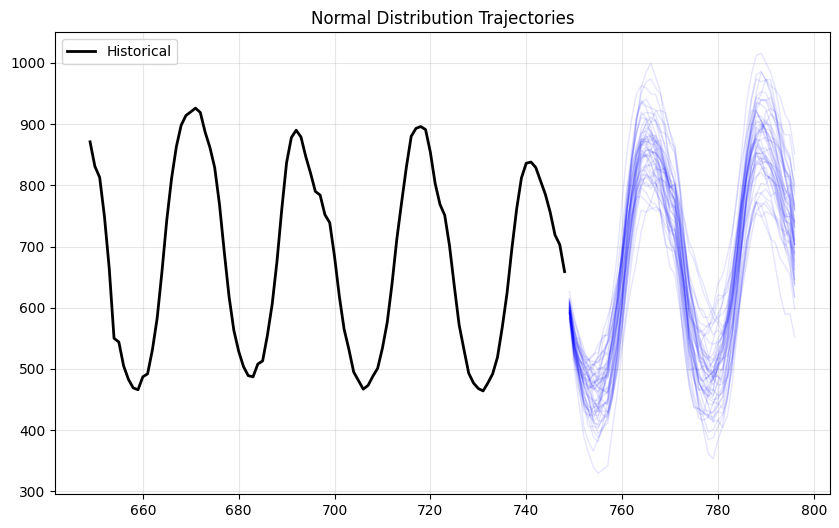

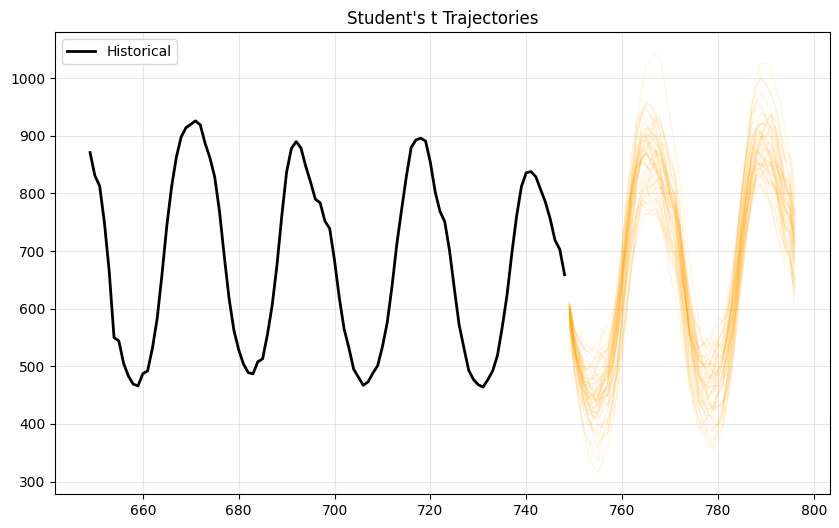

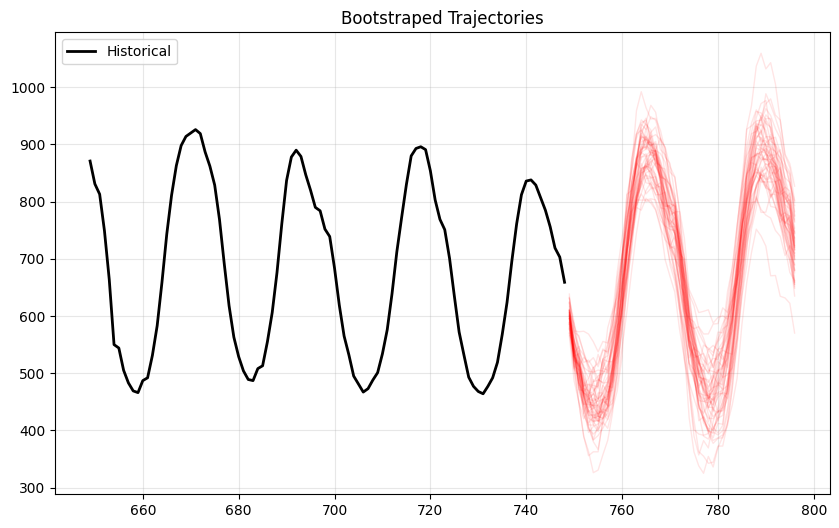

In [14]:
def plot_sims(df, sims, title, color='blue'):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Last 100 historical points
    hist = df.tail(100)
    ax.plot(hist['ds'], hist['y'], color='black', label='Historical', linewidth=2)
    
    # Identify model column
    model_col = [c for c in sims.columns if c not in ['unique_id', 'ds', 'sample_id']][0]
    
    # Plot first 50 simulation paths for clarity
    for x in range(50):
        path = sims[sims['sample_id'] == x]
        ax.plot(path['ds'], path[model_col], color=color, alpha=0.1, linewidth=1)
        
    ax.set_title(title)
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sims(df, sims, 'Normal Distribution Trajectories')
plot_sims(df, sims_t, 'Student\'s t Trajectories', color='orange')
plot_sims(df, sims_boot, 'Bootstraped Trajectories', color='red')

The Student's t distribution (orange) produces a wider variety of paths, including more extreme ones, which is critical for robust risk assessment.

## Handling large simulations

Simulating a very large number of points (`n_series * n_paths * h`) can be memory-intensive. `StatsForecast` will issue a warning if the total number of points exceeds 100,000.

In [9]:
import warnings
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    _ = sf.simulate(df=df, h=24, n_paths=5000)
    if len(w) > 0:
        print(f"Warning caught: {w[-1].message}")

Warning caught: Generating 120,000 simulation points. Large simulations may consume significant memory and time.


## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, The Statistical Forecasting Perspective"](https://otexts.com/fpp3/perspective.html).